# Huffman Kodlama ile Resim Sıkıştırma - Veri Sıkıştırma Final Projesi
   ####   Ecemnur Belgin 20501072

In [1]:
import heapq
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image as im 
from termcolor import colored

#### Huffman Algoritması

In [2]:
class HuffmanCoding:
    def __init__(self, path):
        self.path = path
        self.heap = []
        self.codes = {}
        self.reverse_mapping = {}

    class HeapNode:
        def __init__(self, char, freq):
            self.char = char
            self.freq = freq
            self.left = None
            self.right = None

        def __lt__(self, other):
            return self.freq < other.freq

        def __eq__(self, other):
            if(other == None):
                return False
            if(not isinstance(other, HeapNode)):
                return False
            return self.freq == other.freq

# sıkıştırma fonksiyonu:

    def make_frequency_dict(self, o_image):
        frequency = {}
        for character in o_image:
            if not character in frequency:
                frequency[character] = 0
            frequency[character] += 1
        print(colored('resimdeki piksellerin frekansları:','red', attrs=['bold']))
        print(frequency)
        return frequency

    def make_heap(self, frequency):
        for key in frequency:
            node = self.HeapNode(key, frequency[key])
            heapq.heappush(self.heap, node)
#         print(self.heap)

    def merge_nodes(self):
        while(len(self.heap)>1):
            node1 = heapq.heappop(self.heap)
            node2 = heapq.heappop(self.heap)
            merged = self.HeapNode(None, node1.freq + node2.freq)
            merged.left = node1
            merged.right = node2

            heapq.heappush(self.heap, merged)


    def make_codes_helper(self, root, current_code):
        if(root == None):
            return

        if(root.char != None):
            self.codes[root.char] = current_code
            self.reverse_mapping[current_code] = root.char
            return

        self.make_codes_helper(root.left, current_code + "0")
        self.make_codes_helper(root.right, current_code + "1")


    def make_codes(self):
        root = heapq.heappop(self.heap)
        current_code = ""
        self.make_codes_helper(root, current_code)


    def get_encoded_o_image(self, o_image):
        encoded_o_image = ""
        for character in o_image:
            encoded_o_image += self.codes[character]
        print(colored("Encoded resim bitleri:",'red', attrs=['bold']))
        print(encoded_o_image)
        return encoded_o_image


    def pad_encoded_o_image(self, encoded_o_image):
        extra_padding = 8 - len(encoded_o_image) % 8
        for i in range(extra_padding):
            encoded_o_image += "0"

        padded_info = "{0:08b}".format(extra_padding)
        encoded_o_image = padded_info + encoded_o_image
        return encoded_o_image


    def get_byte_array(self, padded_encoded_o_image):
        if(len(padded_encoded_o_image) % 8 != 0):
            print("Encoded o_image not padded properly")
            exit(0)

        b = bytearray()
        for i in range(0, len(padded_encoded_o_image), 8):
            byte = padded_encoded_o_image[i:i+8]
            b.append(int(byte, 2))
#         print(b)
        return b


    def compress(self):
        filename, file_extension = os.path.splitext(self.path)
        output_path = filename + ".bin"

        with open(output_path, 'wb') as output:
            img = cv2.imread(path,0)
            o_image = img.flatten()

            frequency = self.make_frequency_dict(o_image)
            self.make_heap(frequency)
            self.merge_nodes()
            self.make_codes()
            print(colored('\nKodlanmış sözlük:','red', attrs=['bold']))
            print(self.codes)
            encoded_o_image = self.get_encoded_o_image(o_image)
            padded_encoded_o_image = self.pad_encoded_o_image(encoded_o_image)
            b = self.get_byte_array(padded_encoded_o_image)
            output.write(bytes(b))

        print(colored("\nSıkıştırıldı!",'green',attrs=['bold']))
        return output_path

#  functions for decompression: 
    def remove_padding(self, padded_encoded_o_image):
        padded_info = padded_encoded_o_image[:8]
        extra_padding = int(padded_info, 2)

        padded_encoded_o_image = padded_encoded_o_image[8:] 
        encoded_o_image = padded_encoded_o_image[:-1*extra_padding]
        encoded_o_image = str(encoded_o_image)
        return encoded_o_image

    def decode_o_image(self, encoded_o_image):
        current_code = ""
        decoded_o_image = []
        
        for bit in encoded_o_image:
            current_code += bit
            if(current_code in self.reverse_mapping):
                character = self.reverse_mapping[current_code]
                decoded_o_image.append(character)
                current_code = ""
        return decoded_o_image


    def decompress(self, input_path):
        filename, file_extension = os.path.splitext(self.path)
        output_path = filename + "_decompressed" + ".bmp"

        with open(input_path, 'rb') as file, open(output_path, 'wb') as output:
            bit_string = ""

            byte = file.read(1)
            while(len(byte) > 0):
                byte = ord(byte)
                bits = bin(byte)[2:].rjust(8, '0')
                bit_string += bits
                byte = file.read(1)

            encoded_o_image = self.remove_padding(bit_string)
            img = cv2.imread(path,0)
            decompressed_o_image = self.decode_o_image(encoded_o_image) 
            dec_o_image = [i if i is not None else 0 for i in decompressed_o_image]
            out = np.array(dec_o_image)
            out_array = np.reshape(out,img.shape)
            print(colored('Decoded resim piksel değerleri:','red',attrs=['bold']))
            print(out_array)
            output_img = im.fromarray(out_array.astype(np.uint8))
            output_img.save(output)
        print(colored("\nDekompres edildi",'green',attrs=['bold']))
        return output_path
    

Sıkıştırılacak dosyanın adı:lenna256
Dosyanın uzantısı: .jpg/.png/.jpeg
.png
[[161 161 157 ... 169 169 126]
 [161 161 157 ... 171 169 126]
 [163 155 159 ... 149 124  62]
 ...
 [ 54  46  52 ...  88  92  90]
 [ 42  46  46 ...  96 104  98]
 [ 44  50  46 ... 104 104 108]]
input_image piksel değerleri (quantization sonrası):
[[160 160 160 ... 170 170 130]
 [160 160 160 ... 170 170 130]
 [160 150 160 ... 150 120  60]
 ...
 [ 50  50  50 ...  90  90  90]
 [ 40  50  50 ... 100 100 100]
 [ 40  50  50 ... 100 100 110]] 

input_image boyutu(byte) :
66614 bytes


Sıkıştırılacak resim:


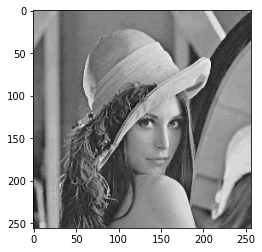

resimdeki piksellerin frekansları:
{160: 4669, 150: 6154, 170: 3076, 140: 5633, 120: 4201, 110: 3471, 100: 4573, 90: 2945, 130: 6031, 180: 2120, 200: 2251, 210: 2241, 220: 600, 190: 1979, 60: 2813, 80: 2202, 50: 4804, 40: 3131, 70: 2019, 230: 82, 20: 38, 30: 481, 240: 5, 10: 13, 250: 3, 0: 1}

Kodlanmış sözlük:
{130: '000', 150: '001', 40: '0100', 220: '010100', 0: '010101000000', 250: '010101000001', 240: '01010100001', 10: '0101010001', 20: '010101001', 230: '01010101', 30: '0101011', 190: '01011', 110: '0110', 70: '01110', 180: '01111', 120: '1000', 80: '10010', 210: '10011', 100: '1010', 160: '1011', 50: '1100', 200: '11010', 60: '11011', 140: '1110', 90: '11110', 170: '11111'}
Encoded resim bitleri:
1011101110111011101110111011001001101100110111011001001001101110111111110111011111111111111111111111111111111101100111101000011010101111010101010101010101010011001101010011001100110011001100110011001100110011001100110100010001000100010001000000100000000000000000000000000000000000000000

Decoded resim piksel değerleri:
[[160 160 160 ... 170 170 130]
 [160 160 160 ... 170 170 130]
 [160 150 160 ... 150 120  60]
 ...
 [ 50  50  50 ...  90  90  90]
 [ 40  50  50 ... 100 100 100]
 [ 40  50  50 ... 100 100 110]]

Dekompres edildi
Decompressed edilen dosya: 
lenna256_decompressed.bmp
Dekompress edilen dosya boyutu (byte):
66614 bytes


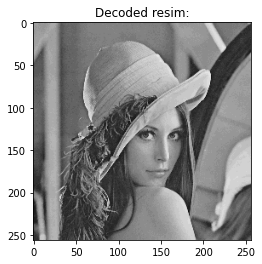

Başarılı!
Input Resim Boyutu:
66614 bytes

Sıkıştırılmış Resim Boyutu:
34365 bytes

compression ratio (output/input):
0.5158825472122978
sıkıştırma yüzdesi:
48.411745278770226


In [11]:
input_path = input("Sıkıştırılacak dosyanın adı:")
input_extension = input('Dosyanın uzantısı: .jpg/.png/.jpeg\n')

img = cv2.imread(input_path + input_extension,0)
print(img)
for i in range(img.shape[0]):
    for j in range(img.shape[1]):
        if (img[i][j] % 10 <= 5):
            img[i][j] = img[i][j] - img[i][j] % 10
        if (img[i][j] % 10 > 5):
            img[i][j] = img[i][j] + (10 - img[i][j] % 10)
print(colored('input_image piksel değerleri (quantization sonrası):','red', attrs=['bold']))
print(img,'\n')
output_img = im.fromarray(img)
output_img.save(input_path + ".bmp")
print(colored('input_image boyutu(byte) :','red', attrs=['bold']))
print(os.stat(input_path + ".bmp").st_size,'bytes\n')
plt.imshow(output_img, cmap= 'gray')
print(colored("\nSıkıştırılacak resim:",'red', attrs=['bold']))
plt.show()
path = input_path + ".bmp"
h = HuffmanCoding(path)


output_path = h.compress()
print(colored("Sıkıştırılan dosya:",'red', attrs=['bold']))
print(output_path)
print(colored("Sıkıştırılan dosya boyutu (byte):",'red', attrs=['bold']))
print(os.stat(output_path).st_size,'bytes\n')

decom_path = h.decompress(output_path)
print(colored("Decompressed edilen dosya: ",'red', attrs=['bold']))
print(decom_path)
print(colored("Dekompress edilen dosya boyutu (byte):",'red', attrs=['bold']))
print(os.stat(decom_path).st_size,'bytes')
decoded_image = cv2.imread(decom_path)
plt.imshow(decoded_image,'gray')
plt.title('Decoded resim:')
plt.show()

print(colored('Başarılı!','green', attrs=['bold']))
print('Input Resim Boyutu:')
print(os.stat(input_path + ".bmp").st_size,'bytes\n')
print('Sıkıştırılmış Resim Boyutu:')
print(os.stat(output_path).st_size,'bytes\n')
print(colored('compression ratio (output/input):','red', attrs=['bold']))
input_img_size = os.stat(input_path + ".bmp").st_size
comp_img_size = os.stat(output_path).st_size
ratio= comp_img_size/input_img_size
print(ratio)
print(colored('sıkıştırma yüzdesi:', 'red', attrs=['bold']))
print(100*(1-ratio))